# Histopathologic Cancer Detector

In [1]:
#Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn

import shutil, os

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D

from keras.layers import Flatten
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [2]:
#Initializing Constants

IMG_HEIGHT = 96
IMG_WIDTH = 96
IMG_CHANNELS = 3

In [3]:
#Reading the data labels from CSV

base_dir = 'D:\Sem2\Deep learning\propro\cancer\histopathologic_cancer_detector-master'
dataset = pd.read_csv(base_dir+'\\train_labels.csv')
X = dataset.iloc[:,0].values
y = dataset.iloc[:,1].values

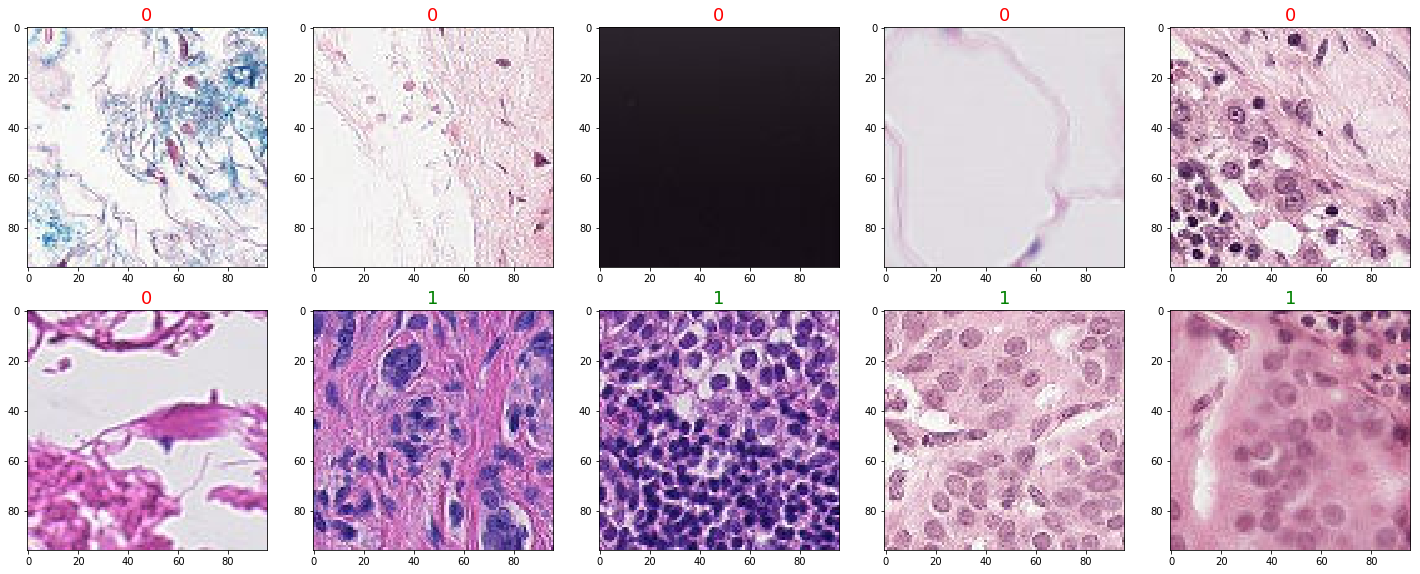

In [4]:
#Visualizing training image samples

fig = plt.figure(figsize = (20,8))
index = 1
for i in np.random.randint(low = 0, high = dataset.shape[0], size = 10):
    file = os.path.join(os.path.join(base_dir,'train'),dataset.iloc[i]['id'] + '.tif')
    img=mpimg.imread(file)
    ax = fig.add_subplot(2, 5, index)
    ax.imshow(img, cmap = 'gray')
    index = index + 1
    color = ['green' if dataset.iloc[i].label == 1 else 'red'][0]
    ax.set_title(dataset.iloc[i].label, fontsize = 18, color = color)
plt.tight_layout()
plt.show()

## Part 1 - Data Preparation

In [7]:
#Encoding the categorical variables

from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

In [8]:
#Distribution of Classes

dataset['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [9]:
#Finding the Class distribution ratio in dataset

data_distribution = dataset[dataset['label']==1].count()/dataset[dataset['label']==0].count()

In [10]:
#Splitting 10% as test set from the original dataset 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0, stratify = y)

In [11]:
#Splitting 10% from the dataset as validation set 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = (0.1/0.9), random_state = 0, stratify = y_train)

In [12]:
train_set_distribution = np.count_nonzero(y_train==1)/(len(y_train) - np.count_nonzero(y_train==1))
print('Training Set Distribution Ratio: {:.2f}'.format(train_set_distribution))
test_set_distribution = np.count_nonzero(y_test==1)/(len(y_test) - np.count_nonzero(y_test==1))
print('Test Set Distribution Ratio: {:.2f}'.format(test_set_distribution))

Training Set Distribution Ratio: 0.68
Test Set Distribution Ratio: 0.68


In [13]:
print('Size of training set:', len(X_train))
print('Size of validation set:', len(X_val))
print('Size of test set:', len(X_test))

Size of training set: 176019
Size of validation set: 22003
Size of test set: 22003


In [13]:
#Creating new dataset folder path for input

base_dest = os.path.join(base_dir,'dataset')

In [26]:
#Creating dataset folder

os.mkdir(base_dest)

NameError: name 'base_dest' is not defined

In [27]:
#Creating new folder paths for training input

source = os.path.join(base_dir,'train')
train_dest = os.path.join(base_dest,'train')
val_dest = os.path.join(base_dest,'val')
test_dest = os.path.join(base_dest,'test')

NameError: name 'base_dest' is not defined

In [28]:
#Creating folders for train/val/test

os.mkdir(train_dest)
os.mkdir(val_dest)
os.mkdir(test_dest)

NameError: name 'train_dest' is not defined

In [29]:
def copy_to_classfolders(source,dest,X,y):
    
    '''
    Function to copy data images to train/validation/test folders according to their classes
    '''
    
    #Creating new folders for each class
    class_zero = os.path.join(dest,'Class_NoTumor')
    class_one = os.path.join(dest,'Class_Tumor')
    os.mkdir(class_zero)
    os.mkdir(class_one)

    #Copying training images according to its class
    for image in X:
        selected_image = image + '.tif'
        source_file = os.path.join(source,selected_image)
        index = np.where(X == image)
        if y[index] == 0:
            dest_file = os.path.join(class_zero,selected_image)
        elif y[index] == 1:
            dest_file = os.path.join(class_one,selected_image)
        shutil.copyfile(source_file, dest_file)

In [19]:
#Copying all images according to the train.val.test split

copy_to_classfolders(source, train_dest, X_train, y_train)
copy_to_classfolders(source, val_dest, X_val, y_val)
copy_to_classfolders(source, test_dest, X_test, y_test)

## Part 2 - Building the CNN Model

In [15]:
# Initialising the CNN
classifier = Sequential()

In [16]:
#Initializing constants for building the model

FILTER_1 = 16
FILTER_2 = 32
FILTER_3 = 64
FILTER_4 = 128

KERNEL_SIZE = (3,3)
DROPOUT_RATE = 0.3
POOL_SIZE = (3,3)

TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1

In [17]:
# Step 1 - First Convolution layer - Dropout and Max Pooling

classifier.add(Convolution2D(filters = FILTER_1, kernel_size = KERNEL_SIZE, padding = 'same', input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), activation = 'relu'))
classifier.add(Convolution2D(filters = FILTER_1, kernel_size = KERNEL_SIZE, padding = 'same', activation = 'relu'))
classifier.add(Convolution2D(filters = FILTER_1, kernel_size = KERNEL_SIZE, padding = 'same', activation = 'relu'))
classifier.add(Dropout(DROPOUT_RATE))
classifier.add(MaxPooling2D(pool_size = POOL_SIZE))

In [18]:
# Step 2 - Second Convolution layer - Dropout and Max Pooling

classifier.add(Convolution2D(filters = FILTER_2, kernel_size = KERNEL_SIZE, padding = 'same', activation = 'relu'))
classifier.add(Convolution2D(filters = FILTER_2, kernel_size = KERNEL_SIZE, padding = 'same', activation = 'relu'))
classifier.add(Convolution2D(filters = FILTER_2, kernel_size = KERNEL_SIZE, padding = 'same', activation = 'relu'))
classifier.add(Dropout(DROPOUT_RATE))
classifier.add(MaxPooling2D(pool_size = POOL_SIZE))

In [19]:
# Step 3 - Third Convolution layer -  Dropout and Max Pooling

classifier.add(Convolution2D(filters = FILTER_3, kernel_size = KERNEL_SIZE, padding = 'same', activation = 'relu'))
classifier.add(Convolution2D(filters = FILTER_3, kernel_size = KERNEL_SIZE, padding = 'same', activation = 'relu'))
classifier.add(Convolution2D(filters = FILTER_3, kernel_size = KERNEL_SIZE, padding = 'same', activation = 'relu'))
classifier.add(Dropout(DROPOUT_RATE))
classifier.add(MaxPooling2D(pool_size = POOL_SIZE))

In [20]:
# Step 4 - Fourth Convolution layer - Dropout

classifier.add(Convolution2D(filters = FILTER_4, kernel_size = KERNEL_SIZE, padding = 'same',activation = 'relu'))
classifier.add(Convolution2D(filters = FILTER_4, kernel_size = KERNEL_SIZE, padding = 'same',activation = 'relu'))
classifier.add(Convolution2D(filters = FILTER_4, kernel_size = KERNEL_SIZE, padding = 'same',activation = 'relu'))
classifier.add(Dropout(DROPOUT_RATE))

In [21]:
# Step 6 - Flattening

classifier.add(Flatten())

In [22]:
# Step 7 - Full connection

classifier.add(Dense(output_dim = 128, activation = 'relu'))
classifier.add(Dropout(DROPOUT_RATE))
classifier.add(Dense(output_dim = 1, activation = 'sigmoid'))

C:\Users\johns\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\johns\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1)`
  """


In [23]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)       

In [24]:
# Compiling the CNN using Adam optimizer

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## Part 3 - Data Generation

In [30]:
#Generating batches of tensor image data for train/val/test images

from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(rescale = 1./255)

training_set = data_gen.flow_from_directory(train_dest,
                                                 target_size = (IMG_HEIGHT,IMG_WIDTH),
                                                 batch_size = TRAIN_BATCH_SIZE,
                                                 class_mode = 'binary')

val_set = data_gen.flow_from_directory(val_dest,
                                            target_size = (IMG_HEIGHT,IMG_WIDTH),
                                            batch_size = VAL_BATCH_SIZE,
                                            class_mode = 'binary',
                                           shuffle=False)

test_set = data_gen.flow_from_directory(test_dest,
                                            target_size = (IMG_HEIGHT,IMG_WIDTH),
                                            batch_size = TEST_BATCH_SIZE,
                                            class_mode = 'binary',
                                           shuffle=False)

NameError: name 'train_dest' is not defined

In [29]:
import keras
print(keras.__version__)
import tensorflow as tf
print(tf.__version__)

2.3.1
1.15.3


## Part 4: Learning on Training Data

In [32]:
#Setting GPU session

from keras import backend as K
cfg = tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(tf.Session(config=cfg))


In [37]:
#Variables for training the model

model_checkpoint = ModelCheckpoint(base_dir+'\\model.h5', monitor='val_acc', verbose=1, 
                            save_best_only=True, mode='max')
csv_logger = CSVLogger(base_dir+'\\Log.log')
early_stopping = EarlyStopping(monitor = 'val_acc',min_delta = 0.000001,patience= 6, verbose = 1, mode = 'max' )

In [ ]:
#Learning on the training set

history = classifier.fit_generator(training_set,
                         steps_per_epoch = np.ceil(len(X_train)/training_set.batch_size),
                         epochs = 4,
                         validation_data = val_set,
                         validation_steps = np.ceil(len(X_val)/val_set.batch_size),
                                  callbacks= [model_checkpoint, early_stopping, csv_logger])

Epoch 1/4
612/612 [==============================] - 7757s 13s/step - loss: 0.4504 - accuracy: 0.7953 - val_loss: 0.2007 - val_accuracy: 0.7048
Epoch 2/4


C:\Users\johns\Anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


548/612 [=========================>....] - ETA: 11:04 - loss: 0.3607 - accuracy: 0.8430

## Part 5: Model Assessment

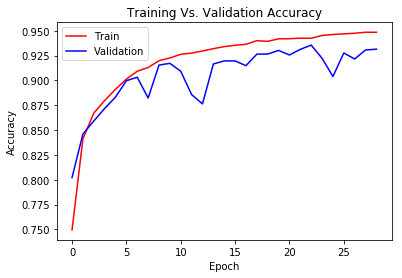

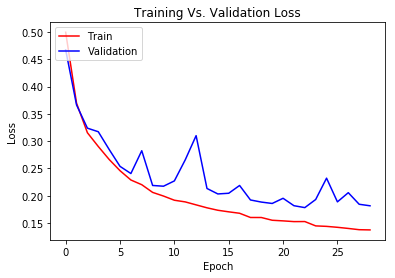

In [32]:
# Plot training & validation accuracy values

plt.plot(history.history['acc'], c = 'red')
plt.plot(history.history['val_acc'], c = 'blue')
plt.title('Training Vs. Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values

plt.plot(history.history['loss'], c = 'red')
plt.plot(history.history['val_loss'], 'blue')
plt.title('Training Vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [33]:
#Loading back the trained model for prediction

classifier.load_weights(base_dir+'\\model.h5')

In [34]:
#Evaluating Generator on the val set to find Accuracy/Loss

score = classifier.evaluate_generator(val_set, steps = len(X_val),verbose = 1, workers= 1, pickle_safe=False)
print('Performance of generated classifier:\n ',score)

C:\Anaconda\envs\python36\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras_pre..., steps=22003, verbose=1, workers=1, use_multiprocessing=False)`
  This is separate from the ipykernel package so we can avoid doing imports until


22003/22003 [==============================] - 2535s 115ms/step
Performance of generated classifier:
  [0.17813773885836048, 0.9355259764273797]


## Part 6: Performance Measurement 

In [35]:
#Predict on the test set

y_pred = classifier.predict_generator(test_set, steps = len(X_test), verbose = 1, workers = 1)
y_true = test_set.classes

22003/22003 [==============================] - 2950s 134ms/step


In [36]:
## Finding ROC Score

from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print('Area under ROC curve: {:.2f}'.format(auc_keras))

Area under ROC curve: 0.98


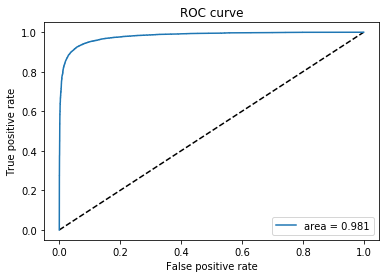

In [37]:
#Plotting ROC Curve

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [38]:
#Confusion matrix using sklearn

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_true, y_pred[:,0].round())
cm_plot_labels = ['0 - No Tumor', '1 - Tumor']

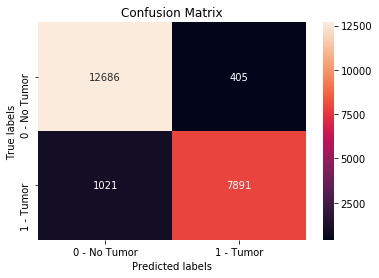

In [39]:
#Plot Confusion Matrix

ax = plt.subplot()
df_cm = pd.DataFrame(cm, range(2),range(2)) 
sn.heatmap(df_cm, annot=True , ax = ax, fmt = 'g')# font size
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(cm_plot_labels); 
ax.yaxis.set_ticklabels(cm_plot_labels);

In [40]:
#Printing Classification Report

from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred[:,0].round(), target_names=cm_plot_labels)
print(report)

              precision    recall  f1-score   support

0 - No Tumor       0.93      0.97      0.95     13091
   1 - Tumor       0.95      0.89      0.92      8912

   micro avg       0.94      0.94      0.94     22003
   macro avg       0.94      0.93      0.93     22003
weighted avg       0.94      0.94      0.93     22003



In [41]:
#Finding accuracy on the test data

print("Accuracy of predictions: {:.2f} %".format(accuracy_score(y_true, y_pred[:,0].round())*100))

Accuracy of predictions: 93.52 %
